In [1]:
# Time and memory tracker
import time
import numexpr
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from functools import wraps
from scipy.special import comb
from memory_profiler import memory_usage, LogFile

%load_ext memory_profiler

# LP Shortest Path
import networkx as nx
from pulp import *
from gurobipy import *

In [2]:
RANDOM_SEED1 = 5 # Set the seed to make repeatable
RANDOM_SEED2 = 6 # Set the seed to make repeatable
NUM_RUNS = 10 # Number of sets of OD pairs to run algorithm with
NUM_EDGES = 10 # Number of edges to sample from wiki dataset

# Test with logarithmically scaled number of edges
NUM_EDGES_2 = 100
NUM_EDGES_3 = 1000
NUM_EDGES_4 = 10000
# NUM_EDGES_5 = 100000 # Or better yet, just exponentiate NUM_EDGES

## Time Tracker Decorator

In [3]:
# Time decorator code adapted from:
#   https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module
# Key changes:
#   time.monotonic() instead of time.time()
#   print_prof_data() function revamped to show function / calls / total / average / max in tabular format

PROF_DATA = {}
DATA_CATEGORIES = {}

def profile(tag):

    def profile_wrapper(fn):

        @wraps(fn)
        def with_profiling(*args, **kwargs):
            start_time = time.monotonic()
        
            ret = fn(*args, **kwargs)
        
            elapsed_time = time.monotonic() - start_time

            if fn.__name__ not in PROF_DATA:
                PROF_DATA[fn.__name__] = [0, []]
            PROF_DATA[fn.__name__][0] += 1
            PROF_DATA[fn.__name__][1].append(elapsed_time)
            if fn.__name__ not in DATA_CATEGORIES:
                DATA_CATEGORIES[fn.__name__] = tag

            return ret

        return with_profiling

    return profile_wrapper

def print_prof_data():
    print("\n{:>25}\t{:>8}\t{:>12}\t{:>12}\t{:>12}\t{:>12}".format("Function", "Calls", "Total", "Average", "Std dev", "Maximum"))
    print(108 * "_" + "\n")
    total_calls = 0
    grand_time = 0
    for fname, data in PROF_DATA.items():
        total_calls += data[0]
        total_time = sum(data[1])
        grand_time += total_time
        avg_time = np.mean(data[1])
        std_time = np.std(data[1])
        max_time = max(data[1])
        print("{:>25s}\t{:8d}\t{:12.6f}\t{:12.6f}\t{:12.6f}\t{:12.6f}".format(fname + " — " + DATA_CATEGORIES[fname], data[0], total_time, avg_time, std_time, max_time))
    print(108 * "_")
    print("\n{:>25}\t{:8d}\t{:>12.6f}\t{:12.6f}".format("ALL FUNCTIONS COMBINED", total_calls, grand_time, grand_time / total_calls))

def clear_prof_data():
    global PROF_DATA
    PROF_DATA = {}

def clear_data_categories():
    global DATA_CATEGORIES
    DATA_CATEGORIES = {}
    
def organize_result(PROF_DATA, DATA_CATEGORIES):
    # We can also export PROF_DATA to a DataFrame for nicer display and possibly also for future use
    # Display the refined dataframe so that …
    #   1. It suppresses the individual times, without deleting that information
    #   2. It is sorted in descending order of total time taken

    profile_frame = pd.DataFrame(PROF_DATA)
    profile_frame = profile_frame.transpose()
    profile_frame.columns = ["calls", "times"]
    profile_frame["total"] = profile_frame.times.map(sum)
    profile_frame["average"] = profile_frame.times.map(np.mean)
    profile_frame["std_dev"] = profile_frame.times.map(np.std)
    profile_frame["maximum"] = profile_frame.times.map(max)
    profile_frame["minimum"] = profile_frame.times.map(min)
    for function in profile_frame.index:
        profile_frame.loc[function, "category"] = DATA_CATEGORIES[function]

    print("\t*** Timekeeping summary of profiled functions ***\n")
    print("{:d} profiled functions took {:d} calls for {:.6f} total seconds, an average of {:.6f}.".format(len(profile_frame), profile_frame.calls.sum(), profile_frame.total.sum(), profile_frame.total.mean()))

    results = profile_frame.loc[:, ["category", "calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False)
    
    return profile_frame, results

### Test and POC of the Time Tracker Decorator

In [4]:
# Test the time decorator function — Set up

@profile("numpy")
def factorial(n):
    """Assumes n is an integer > 0
        Returns n!"""
    if n == 0:
        return 1
    elif n == 1:
        return n
    else:
        return n * factorial(n - 1)

@profile("numpy")
def permutations(n, r):
    """ Assumes n, k are integers > 0
        Returns nPr """
    nPr = factorial(n)/factorial(n - r)
    nPr = int(round(nPr))
    return nPr

@profile("numpy")
def combinations(n, r):
    """ Assumes n, k are integers > 0
        Returns nCr """
    nCr = permutations(n, r)/factorial(r)
    nCr = int(round(nCr))
    return nCr

# Test the time decorator function — Write a tiny Fibonnaci triangle

for i in range(0, 13):
    for j in range(i + 1):
        print(combinations(i, j), "\t", end = "")
        # print("C({:d}, {:d}) = {:d}\t".format(i, j, combinations(i, j)), end = "")
    print("\n")

print_prof_data()

1 	

1 	1 	

1 	2 	1 	

1 	3 	3 	1 	

1 	4 	6 	4 	1 	

1 	5 	10 	10 	5 	1 	

1 	6 	15 	20 	15 	6 	1 	

1 	7 	21 	35 	35 	21 	7 	1 	

1 	8 	28 	56 	70 	56 	28 	8 	1 	

1 	9 	36 	84 	126 	126 	84 	36 	9 	1 	

1 	10 	45 	120 	210 	252 	210 	120 	45 	10 	1 	

1 	11 	55 	165 	330 	462 	462 	330 	165 	55 	11 	1 	

1 	12 	66 	220 	495 	792 	924 	792 	495 	220 	66 	12 	1 	


                 Function	   Calls	       Total	     Average	     Std dev	     Maximum
____________________________________________________________________________________________________________

        factorial — numpy	    1483	    0.000000	    0.000000	    0.000000	    0.000000
     permutations — numpy	      91	    0.000000	    0.000000	    0.000000	    0.000000
     combinations — numpy	      91	    0.000000	    0.000000	    0.000000	    0.000000
____________________________________________________________________________________________________________

   ALL FUNCTIONS COMBINED	    1665	    0.000000	    0.000000


In [5]:
# Test the time decorator function — Set up

@profile("scipy")
def scipy_comb(n, r):
    """ Assumes n, k are integers > 0
        Returns nCr """
    nCr = comb(n, r, exact = True)
    # nCr = int(round(nCr))
    return nCr

# Test the time decorator function — Write a tiny Fibonnaci triangle

for i in range(0, 13):
    for j in range(i + 1):
        print(scipy_comb(i, j), "\t", end = "")
        # print("C({:d}, {:d}) = {:d}\t".format(i, j, combinations(i, j)), end = "")
    print("\n")

print_prof_data()

1 	

1 	1 	

1 	2 	1 	

1 	3 	3 	1 	

1 	4 	6 	4 	1 	

1 	5 	10 	10 	5 	1 	

1 	6 	15 	20 	15 	6 	1 	

1 	7 	21 	35 	35 	21 	7 	1 	

1 	8 	28 	56 	70 	56 	28 	8 	1 	

1 	9 	36 	84 	126 	126 	84 	36 	9 	1 	

1 	10 	45 	120 	210 	252 	210 	120 	45 	10 	1 	

1 	11 	55 	165 	330 	462 	462 	330 	165 	55 	11 	1 	

1 	12 	66 	220 	495 	792 	924 	792 	495 	220 	66 	12 	1 	


                 Function	   Calls	       Total	     Average	     Std dev	     Maximum
____________________________________________________________________________________________________________

        factorial — numpy	    1483	    0.000000	    0.000000	    0.000000	    0.000000
     permutations — numpy	      91	    0.000000	    0.000000	    0.000000	    0.000000
     combinations — numpy	      91	    0.000000	    0.000000	    0.000000	    0.000000
       scipy_comb — scipy	      91	    0.000000	    0.000000	    0.000000	    0.000000
_____________________________________________________________________________________

In [6]:
profile_frame, result = organize_result(PROF_DATA, DATA_CATEGORIES)
result

	*** Timekeeping summary of profiled functions ***

4 profiled functions took 1756 calls for 0.000000 total seconds, an average of 0.000000.


,category,calls,total,average,std_dev,maximum,minimum
factorial,numpy,1483,0.0,0.0,0.0,0.0,0.0
permutations,numpy,91,0.0,0.0,0.0,0.0,0.0
combinations,numpy,91,0.0,0.0,0.0,0.0,0.0
scipy_comb,scipy,91,0.0,0.0,0.0,0.0,0.0


             calls  total  average  std_dev  maximum  minimum
factorial     1483    0.0      0.0      0.0      0.0      0.0
permutations    91    0.0      0.0      0.0      0.0      0.0
combinations    91    0.0      0.0      0.0      0.0      0.0


           calls  total  average  std_dev  maximum  minimum
scipy_comb    91    0.0      0.0      0.0      0.0      0.0


category
numpy    0.0
scipy    0.0
Name: total, dtype: float64


factorial       0.0
permutations    0.0
combinations    0.0
scipy_comb      0.0
Name: total, dtype: float64


([<matplotlib.patches.Wedge at 0x1d01288cd30>,
 [Text(1.15,0,'factorial'),
  Text(1.15,0,'permutations'),
  Text(1.15,0,'combinations'),
  Text(1.3,0,'scipy_comb')])

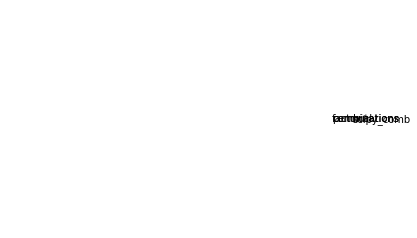

In [22]:
print(profile_frame[profile_frame.category == "numpy"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False))
print('\n')
print(profile_frame[profile_frame.category == "scipy"].loc[:, ["calls", "total", "average", "std_dev", "maximum", "minimum"]].sort_values(by = "total", ascending = False))
print('\n')
print(profile_frame.total.groupby(profile_frame.category).sum())
print('\n')
print(profile_frame["total"])
plt.pie(profile_frame.total * 100, explode = (0.05, 0.05, 0.05, 0.2), labels = profile_frame.index)

In [8]:
# ERROR: TypeError: Image data of dtype object cannot be converted to float
# plt.figure(figsize = (9, 5.5))
# plt.imshow([profile_frame.loc["combinations", "times"], 
#             profile_frame.loc["permutations", "times"], profile_frame.loc["scipy_comb", "times"]], aspect = "auto", interpolation = "none", cmap = "viridis")
# plt.colorbar()
# plt.savefig("profile_frame_time_matrix.png")

# The Algorithms

### Define common data and functions

In [11]:
def initiate_graph(num_edges):
    #G = nx.read_gexf('./data/math_wikipedia_pages_links_dict.gexf')
    G = nx.read_gexf(r'C:\Users\jsalafatinos\OneDrive Personal\OneDrive\NW Data Science\Decision Analytics\math_wikipedia_pages_links_dict.gexf')
    G_2 = G.to_directed()
    

    # Choose subset of wikipedia dataset to test algorithms
    def random_subset_of_arcs(arcs, subset_size):
      """Used to take a random subset of arcs and return a sample
      Can be used in conjunction with the below sampled_edges in a loop"""
      num_arcs = len(arcs)
      selections = random.sample(range(1,num_arcs), subset_size)
      return selections

    def choose_random_nodes(list_of_nodes):
      """Chooses 2 random nodes for testing"""
      num_nodes = len(list_of_nodes)
      node_a, node_b = random.sample(range(0,num_nodes),2)
      return (node_a, node_b)

    # Returns edge samples # Can be used to create a subgraph
    sampled_edges = list(map(list(G.edges).__getitem__, random_subset_of_arcs(list(G.edges),num_edges)))

    # Looks up the nodes in the sampled edges and returns that
    sampled_nodes = list(pd.Series([node for edge in sampled_edges for node in edge]).unique())

    return sampled_nodes, sampled_edges
    
# Define all different sets of sampled nodes and edges
sampled_nodes_1, sampled_edges_1 = initiate_graph(NUM_EDGES)
sampled_nodes_2, sampled_edges_2 = initiate_graph(NUM_EDGES**2) # NUM_EDGES = 10. We can safely exponentiate
sampled_nodes_3, sampled_edges_3 = initiate_graph(NUM_EDGES**3)
sampled_nodes_4, sampled_edges_4 = initiate_graph(NUM_EDGES**4)

# Define nodes to test with for each NUM_EDGES_ value
random.seed(RANDOM_SEED1)
start_nodes_keys_list_1 = random.sample(sampled_nodes_1,NUM_RUNS)
random.seed(RANDOM_SEED2)
end_nodes_keys_list_1 = random.sample(sampled_nodes_1,NUM_RUNS)

random.seed(RANDOM_SEED1)
start_nodes_keys_list_2 = random.sample(sampled_nodes_2,NUM_RUNS)
random.seed(RANDOM_SEED2)
end_nodes_keys_list_2 = random.sample(sampled_nodes_2,NUM_RUNS)

random.seed(RANDOM_SEED1)
start_nodes_keys_list_3 = random.sample(sampled_nodes_3,NUM_RUNS)
random.seed(RANDOM_SEED2)
end_nodes_keys_list_3 = random.sample(sampled_nodes_3,NUM_RUNS)

random.seed(RANDOM_SEED1)
start_nodes_keys_list_4 = random.sample(sampled_nodes_4,NUM_RUNS)
random.seed(RANDOM_SEED2)
end_nodes_keys_list_4 = random.sample(sampled_nodes_4,NUM_RUNS)

In [12]:
# # Initiating new time tracker
clear_prof_data()
clear_data_categories()


### Define general functions for LPs

In [13]:
def create_arcs(sampled_nodes, sampled_edges, start_node_key, end_node_key): 

    # Creates a dictionary of the node IDs to the values for later lookup and reverse lookup
    nodes_ = sampled_nodes
    nodes_dict = dict(zip(range(0,len(nodes_)),nodes_)) #    {0: 'Hanover', 1: 'Gottfried_Wilhelm_Leibniz',..}
    nodes_dict_rev = dict(zip(nodes_,range(0,len(nodes_))))# {'Hanover': 0,'Gottfried_Wilhelm_Leibniz': 1,..}
    nodes_ = list(nodes_dict.keys())

    # Define start and end node. Node A to B
    start_node = nodes_dict_rev[start_node_key]
    end_node = nodes_dict_rev[end_node_key]

    # Create a dictionary of nodes and their net demands
    # Iterates through each node and adds it to the node demand
    # dictionary with a net demand of 0, then sets the supply
    # and demand node of the network problem to -1 and 1respectively
    net_ds_nodes_ = {} #{0: [-1, 0], 1: [0, 0], 2: [0, 0],... 8: [0,1], ... }
    for node in nodes_:
        net_ds_nodes_[node] = [0,0]
    net_ds_nodes_[start_node] = [-1,0]
    net_ds_nodes_[end_node] = [0,1]

    #Creates a dictionary of arcs3
    arcs_ = sampled_edges

    #Creates a dictionary for each arc and swapping the node values for node IDs
    arcs_dict = {}
    """
    example output for arcs_dict:
    {(0, 1): ('Hanover', 'Gottfried_Wilhelm_Leibniz'),
     (0, 2): ('Hanover', 'Carl_Friedrich_Gauss'),
    """
    for a,b in arcs_:
        x = nodes_dict_rev[a]
        y = nodes_dict_rev[b]
        arcs_dict[(x,y)] = (a,b)

    arcs_ = list(arcs_dict.keys())
    return nodes_, arcs_, net_ds_nodes_, start_node, end_node

def run_LP(prob_):
    prob_.solve()    
    return value(prob_.objective)

## Base Linear Program

### Define base LP

In [14]:
def define_base_lp(nodes_, arcs_, net_ds_nodes_, start_node, end_node):
    # Costs, lower bound, upper bound
    arcData_ = dict(zip(arcs_, [[1,0,1]]*len(arcs_)))

    # Makes it easy to reference a dictionary with subdicts
    supply_,demand_ = splitDict(net_ds_nodes_)
    (costs_,mins_,maxs_) = splitDict(arcData_)

    # Create LP Problem    
    prob_ = LpProblem("Shortest Path, Minimum Cost Problem",LpMinimize)

    # Create variables
    LpVars_ = LpVariable.dicts("Route", arcs_, 0, None, LpInteger)

    # Set bounds on variables
    for a in arcs_:
        LpVars_[a].bounds(mins_[a], maxs_[a])

    #Objective Function
    prob_ += lpSum([LpVars_[a]  for a in arcs_]), "Shortest Path" 
  
    # Constraints:
    #For each node that is not a start node or end note, set the inflow = outflow so that the
    #"path" of clicks must go THROUGH the node
    for n in nodes_:
        if ((n == start_node) or (n == end_node)):
            continue
        #Balance-of-flow constraints [ inflow - outflow  = net demand]
        # since net demand is 0 for most of the nodes, inflow = outflow is the constraint
        prob_ += (lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == n]) - lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == n])) == 0,\
                 "Flow Conservation in Node {}".format(n)

    #Start and end node constraints, indicating supply node (-1) and demand node (1).
    #AKA the sender node (-1) and the receiver node (1)
    # prob_ += -lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == start_node]) == -1
    # prob_ += lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == end_node]) == 1

    prob_ += (lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == start_node]) -\
             lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == start_node])) == -1

    prob_ += (lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if j == end_node]) -\
             lpSum([LpVars_[(i,j)] for (i,j) in arcs_ if i == end_node])) == 1

    #prob_.constraints
    prob_.writeLP(r"network_flow_wikipedia.lp")
    
    return prob_

In [15]:
# The Gurobi implementation of the base LP

def define_gurobi_base_lp(nodes_, arcs_, net_ds_nodes_, start_node, end_node):

    # As feasible, use *exactly* the same definitions of costs, bounds, dictionaries, and subdicts as PuLP
    
    # Costs, lower bound, upper bound
    arcData_ = dict(zip(arcs_, [[1,0,1]] * len(arcs_)))
    

    # Makes it easy to reference a dictionary with subdicts
    supply_, demand_ = splitDict(net_ds_nodes_)
   
    (costs_, mins_, maxs_) = splitDict(arcData_)
   

    try:  # Typical Gurobi code is run within a try/except loop to catch potential errors
        

        # Here we created a dictionary of the arcs as the keys, and the values as the cost. Looks like this:
        # {(1,4): 1,
        #  (3,7): 1,
        #   etc...} 

        # The multidict is a gurobi function that allows you to reference the dict.keys() and dict.values()
        # easily. We called them arcs, cost
        arcs, cost = multidict(dict(zip(arcs_,[1]*len(arcs_))))

        #Init model
        m = Model("Gurobi_base_LP")

        # Here we add the arcs as variables to "flow". We use obj = cost to say that the objective
        # is to minimize the cost (which is 1 for every edge). Gurobi's default is to MINIMIZE,
        # and has a feature where you can declare the objective right in the definition of the variables.
        flow = m.addVars(arcs, obj=cost, name="flow")


        # Here we add the constraints for the "intermediate nodes" where their inflows - outflows = 0.
        # The arcs.select() is a gurobi function that allows us a wildcard selection. This is the key
        # as it allows us to avoid the list comprehension that was screwing us over. 
        m.addConstrs(
          (quicksum(flow[i,j] for i,j in arcs.select('*',j)) ==
            quicksum(flow[j,k] for j,k in arcs.select(j,'*'))
            for j in nodes_ if not((j == start_node) or (j==end_node))), "node")

        m.addConstrs(
          (quicksum(flow[i,j] for i,j in arcs.select('*',j)) -
            quicksum(flow[j,k] for j,k in arcs.select(j,'*')) == -1
            for j in nodes_ if (j == start_node)), "start_node")

        m.addConstrs(
          (quicksum(flow[i,j] for i,j in arcs.select('*',j)) -
            quicksum(flow[j,k] for j,k in arcs.select(j,'*')) == 1
            for j in nodes_ if (j == end_node)), "end_node")

        # Compute optimal solution
        m.optimize()

        # Print solution
        if m.status == GRB.Status.OPTIMAL:
            solution = m.getAttr('x', flow)

            for i,j in arcs:
                if solution[i,j] > 0:
                    print('%s -> %s: %g' % (i, j, solution[i,j]))
    
    except GurobiError as e:
        print('Error code ' + str(e.errno) + ": " + str(e))

    except AttributeError:
        print('Encountered an attribute error')

    # This is where the other base_lp routine expects a return. But what? — Let's try m, the whole model
        
    return m  # This passes the entire model "m" back as the value returned by this function

In [17]:
# Gurobi version!

def run_gurobi_lp(prob_):
    prob_.optimize()    
    return prob_.objVal

# Functions for time tracking, separate function for each number of edges
@profile("gurobi_base_lp")
def run_gurobi_base_lp_1(prob):
    return run_gurobi_lp(prob)

@profile("gurobi_base_lp")
def run_gurobi_base_lp_2(prob):
    return run_gurobi_lp(prob)

@profile("gurobi_base_lp")
def run_gurobi_base_lp_3(prob):
    return run_gurobi_lp(prob)

@profile("gurobi_base_lp")
def run_gurobi_base_lp_4(prob):
    return run_gurobi_lp(prob)

# Functions for memory tracking, separate functions for each number of edges
def run_gurobi_base_lp_once_1():
    start_node_key = start_nodes_keys_list_1[0]
    end_node_key = end_nodes_keys_list_1[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)

def run_gurobi_base_lp_once_2():
    start_node_key = start_nodes_keys_list_2[0]
    end_node_key = end_nodes_keys_list_2[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)

def run_gurobi_base_lp_once_3():
    start_node_key = start_nodes_keys_list_3[0]
    end_node_key = end_nodes_keys_list_3[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)
    
def run_gurobi_base_lp_once_4():
    start_node_key = start_nodes_keys_list_4[0]
    end_node_key = end_nodes_keys_list_4[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_gurobi_lp(prob)

# Time tracking, run each model NUM_RUNS times
for i in range(0,NUM_RUNS): 
    start_node_key = start_nodes_keys_list_1[i]
    end_node_key = end_nodes_keys_list_1[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_gurobi_base_lp_1(prob)

    start_node_key = start_nodes_keys_list_2[i]
    end_node_key = end_nodes_keys_list_2[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_gurobi_base_lp_2(prob)
   
    start_node_key = start_nodes_keys_list_3[i]
    end_node_key = end_nodes_keys_list_3[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_gurobi_base_lp_3(prob)
       
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_gurobi_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_gurobi_base_lp_4(prob)

MEMORY_INTERVAL = 0.01  # Switch from the default interval value of 0.1 seconds for memory_usage    

# Memory tracking
gurobi_base_lp_memory_1 = memory_usage(run_gurobi_base_lp_once_1, interval = MEMORY_INTERVAL)
gurobi_base_lp_memory_2 = memory_usage(run_gurobi_base_lp_once_2, interval = MEMORY_INTERVAL)
gurobi_base_lp_memory_3 = memory_usage(run_gurobi_base_lp_once_3, interval = MEMORY_INTERVAL)
gurobi_base_lp_memory_4 = memory_usage(run_gurobi_base_lp_once_4, interval = MEMORY_INTERVAL)

{(0, 1): [1, 0, 1], (2, 3): [1, 0, 1], (4, 5): [1, 0, 1], (6, 7): [1, 0, 1], (8, 9): [1, 0, 1], (10, 11): [1, 0, 1], (12, 13): [1, 0, 1], (14, 15): [1, 0, 1], (16, 17): [1, 0, 1], (18, 19): [1, 0, 1]} 
 [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11), (12, 13), (14, 15), (16, 17), (18, 19)] 


{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: -1} 
 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0} 


{(0, 1): 1, (2, 3): 1, (4, 5): 1, (6, 7): 1, (8, 9): 1, (10, 11): 1, (12, 13): 1, (14, 15): 1, (16, 17): 1, (18, 19): 1} 
 {(0, 1): 0, (2, 3): 0, (4, 5): 0, (6, 7): 0, (8, 9): 0, (10, 11): 0, (12, 13): 0, (14, 15): 0, (16, 17): 0, (18, 19): 0} 
 {(0, 1): 1, (2, 3): 1, (4, 5): 1, (6, 7): 1, (8, 9): 1, (10, 11): 1, (12, 13): 1, (14, 15): 1, (16, 17): 1, (18, 19): 1} 


Optimize a model with 20 rows, 10 columns and 20 nonzeros
Coeffic

AttributeError: b"Unable to retrieve attribute 'objVal'"

###  Running the base LP

In [18]:
# Functions for time tracking, separate function for each number of edges
@profile("base_lp")
def run_base_lp_1(prob):
    return run_LP(prob)

@profile("base_lp")
def run_base_lp_2(prob):
    return run_LP(prob)

@profile("base_lp")
def run_base_lp_3(prob):
    return run_LP(prob)

@profile("base_lp")
def run_base_lp_4(prob):
    return run_LP(prob)

# Functions for memory tracking, separate functions for each number of edges
def run_base_lp_once_1():
    start_node_key = start_nodes_keys_list_1[0]
    end_node_key = end_nodes_keys_list_1[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)

def run_base_lp_once_2():
    start_node_key = start_nodes_keys_list_2[0]
    end_node_key = end_nodes_keys_list_2[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)

def run_base_lp_once_3():
    start_node_key = start_nodes_keys_list_3[0]
    end_node_key = end_nodes_keys_list_3[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    
def run_base_lp_once_4():
    start_node_key = start_nodes_keys_list_4[0]
    end_node_key = end_nodes_keys_list_4[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)

# Time tracking, run each model NUM_RUNS times
for i in range(0,NUM_RUNS): 
    start_node_key = start_nodes_keys_list_1[i]
    end_node_key = end_nodes_keys_list_1[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_base_lp_1(prob)

    start_node_key = start_nodes_keys_list_2[i]
    end_node_key = end_nodes_keys_list_2[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_base_lp_2(prob)
   
    start_node_key = start_nodes_keys_list_3[i]
    end_node_key = end_nodes_keys_list_3[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_base_lp_3(prob)
       
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_base_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_base_lp_4(prob)

MEMORY_INTERVAL = 0.01  # Switch from the default interval value of 0.1 seconds for memory_usage    

# Memory tracking
base_lp_memory_1 = memory_usage(run_base_lp_once_1, interval = MEMORY_INTERVAL)
base_lp_memory_2 = memory_usage(run_base_lp_once_2, interval = MEMORY_INTERVAL)
base_lp_memory_3 = memory_usage(run_base_lp_once_3, interval = MEMORY_INTERVAL)
base_lp_memory_4 = memory_usage(run_base_lp_once_4, interval = MEMORY_INTERVAL)

## Dual Linear Program

### Define the dual LP

In [19]:
def define_dual_lp(nodes_, arcs_, net_ds_nodes_, start_node, end_node):    
    # Create LP Problem    
    prob_ = LpProblem("Shortest Path, Minimum Cost Problem",LpMaximize)
    
    # Create variables
    LpVars_ = LpVariable.dicts("Nodes", nodes_, 0, None, LpInteger)
    
    # Objective Function
    prob_ += lpSum(-LpVars_[start_node] + LpVars_[end_node]), "Shortest Path"
    
    for e in arcs_:
        u = LpVars_[e[0]]
        v = LpVars_[e[1]]
        prob_ += v - u  <= 1, "Constraint at each Edge {}".format(e)

    prob_ += LpVars_[start_node] == 0
    return prob_

### Running the dual LP

In [20]:
# Functions for time tracking, separate function for each number of edges
@profile("dual_lp")
def run_dual_lp_1(prob):
    return run_LP(prob)

@profile("dual_lp")
def run_dual_lp_2(prob):
    return run_LP(prob)

@profile("dual_lp")
def run_dual_lp_3(prob):
    return run_LP(prob)

@profile("dual_lp")
def run_dual_lp_4(prob):
    return run_LP(prob)

# Function for memory tracking, separate function for each number of edges
def run_dual_lp_once_1():
    start_node_key = start_nodes_keys_list_1[0]
    end_node_key = end_nodes_keys_list_1[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)

def run_dual_lp_once_2():
    start_node_key = start_nodes_keys_list_2[0]
    end_node_key = end_nodes_keys_list_2[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)

def run_dual_lp_once_3():
    start_node_key = start_nodes_keys_list_3[0]
    end_node_key = end_nodes_keys_list_3[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)
    
def run_dual_lp_once_4():
    start_node_key = start_nodes_keys_list_4[0]
    end_node_key = end_nodes_keys_list_4[0]

    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    clicks = run_LP(prob)

# Time tracking, run each model NUM_RUNS times
for i in range(0,NUM_RUNS): 
    start_node_key = start_nodes_keys_list_1[i]
    end_node_key = end_nodes_keys_list_1[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_1, sampled_edges_1, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_dual_lp_1(prob)

    start_node_key = start_nodes_keys_list_2[i]
    end_node_key = end_nodes_keys_list_2[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_2, sampled_edges_2, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_dual_lp_2(prob)
   
    start_node_key = start_nodes_keys_list_3[i]
    end_node_key = end_nodes_keys_list_3[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_3, sampled_edges_3, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_dual_lp_3(prob)
       
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    nodes, arcs, net_ds_nodes, start_node, end_node = create_arcs(sampled_nodes_4, sampled_edges_4, start_node_key, end_node_key)
    prob = define_dual_lp(nodes, arcs, net_ds_nodes, start_node, end_node)
    run_dual_lp_4(prob)
    
# Memory tracking
dual_lp_memory_1 = memory_usage(run_dual_lp_once_1, interval = MEMORY_INTERVAL)
dual_lp_memory_2 = memory_usage(run_dual_lp_once_2, interval = MEMORY_INTERVAL)
dual_lp_memory_3 = memory_usage(run_dual_lp_once_3, interval = MEMORY_INTERVAL)
dual_lp_memory_4 = memory_usage(run_dual_lp_once_4, interval = MEMORY_INTERVAL)

## Dijkstra's Shortest Path

In [21]:
G = nx.read_gexf('./data/math_wikipedia_pages_links_dict.gexf')
G_2 = G.to_directed()

FileNotFoundError: [Errno 2] No such file or directory: './data/math_wikipedia_pages_links_dict.gexf'

In [ ]:
# Running Dijkstra on all of wikipedia
@profile("dijkstra")
def run_dijkstra(i): 
    start_node_key = start_nodes_keys_list_4[i]  # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_4[i]  # Same issue as the previous line
    shortest_path = nx.dijkstra_path(G_2,source = start_node_key, target = end_node_key)

def run_dijkstra_once():
    start_node_key = start_nodes_keys_list_4[0] # was: "start_nodes_keys_list" — This generated an error
    end_node_key = end_nodes_keys_list_4[0]  # Same issue
    shortest_path = nx.dijkstra_path(G_2,source = start_node_key, target = end_node_key)

# Time tracking    
for n in range(0,NUM_RUNS): 
    run_dijkstra(n)
    
# Memory tracking
dijkstra_memory = memory_usage(run_dijkstra_once, interval = MEMORY_INTERVAL)

## A-star (A*) Shortest Path

In [18]:
# Running A* on all of wikipedia
@profile("a*")
def run_astar(i): 
    start_node_key = start_nodes_keys_list_4[i]
    end_node_key = end_nodes_keys_list_4[i]
    shortest_path = nx.astar_path(G_2,source = start_node_key, target = end_node_key)

def run_astar_once():
    start_node_key = start_nodes_keys_list_4[0]
    end_node_key = end_nodes_keys_list_4[0]
    shortest_path = nx.astar_path(G_2,source = start_node_key, target = end_node_key)

# Time tracking    
for n in range(0,NUM_RUNS): 
    run_astar(n)
    
# Memory tracking
# astar_memory = memory_usage(run_astar_once)
astar_memory = memory_usage(run_astar_once, interval = MEMORY_INTERVAL)

# Time Results

In [19]:
profile_frame, result = organize_result(PROF_DATA, DATA_CATEGORIES)
result

	*** Timekeeping summary of profiled functions ***

10 profiled functions took 100 calls for 14.329039 total seconds, an average of 1.432904.


,category,calls,total,average,std_dev,maximum,minimum
run_base_lp_4,base_lp,10,5.049850,0.504985,0.051063,0.640240,0.450137
run_dual_lp_4,dual_lp,10,3.962581,0.396258,0.023958,0.435336,0.353722
run_dijkstra,dijkstra,10,1.759805,0.175980,0.119271,0.349781,0.010030
run_astar,a*,10,1.614852,0.161485,0.110371,0.320810,0.010020
run_dual_lp_3,dual_lp,10,0.685104,0.068510,0.019602,0.100088,0.048466
run_base_lp_3,base_lp,10,0.563671,0.056367,0.004993,0.066109,0.050172
run_base_lp_1,base_lp,10,0.185448,0.018545,0.009858,0.046400,0.012903
run_dual_lp_2,dual_lp,10,0.184147,0.018415,0.003263,0.027813,0.015929
run_base_lp_2,base_lp,10,0.167849,0.016785,0.000950,0.018851,0.015504
run_dual_lp_1,dual_lp,10,0.155732,0.015573,0.006455,0.034884,0.012713


In [49]:
profile_frame.loc["run_base_lp_4", "times"], profile_frame.loc["run_astar", "times"]

([0.4501370929999986,
  0.47048260199999703,
  0.5215864890000006,
  0.6402398009999999,
  0.5105494879999952,
  0.4699265800000063,
  0.4805317940000009,
  0.5328062559999864,
  0.4842646379999991,
  0.48932568400000775],
 [0.20840527199999315,
  0.26699119700001006,
  0.2673305060000075,
  0.3208103789999939,
  0.06712428499997714,
  0.2650783160000003,
  0.02214194300000827,
  0.11154284799999914,
  0.0754068669999981,
  0.010020429999997305])

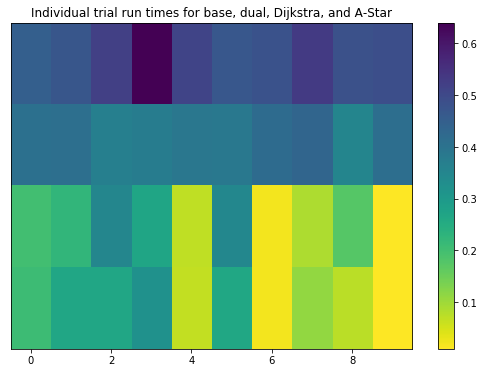

In [52]:
plt.figure(figsize = (9, 6))
plt.title("Individual trial run times for base, dual, Dijkstra, and A-Star")
plt.imshow([profile_frame.loc["run_base_lp_4", "times"], profile_frame.loc["run_dual_lp_4", "times"],
            profile_frame.loc["run_dijkstra", "times"], profile_frame.loc["run_astar", "times"]],
            aspect = "auto", interpolation = "none", cmap = "viridis_r")
plt.yticks([])
plt.colorbar()
plt.savefig("profile_frame_time_matrix.png")

# Memory Results

In [53]:
def max_minus_min(function):
    gap = np.max(function) - np.min(function)
    return gap

def max_minus_last(function):
    gap = np.max(function) - function[len(function) - 1]
    return gap

def max_minus_first(function):
    gap = np.max(function) - function[0]
    return gap

def solo_memory_report(func_1, label_1):

    print("Peak memory usage for {}:\t{:11.6f}".format(label_1, max_minus_min(func_1)))
    
    plt.grid()
    plt.title("Memory usage for " + label_1)
    plt.plot(func_1 - np.min(func_1), color = "red", label = label_1)
    # plt.plot(func_2 - np.min(func_2), color = "red", label = label_2)
    plt.xlabel("Execution time (in tenths of a second)", fontsize = 12)
    plt.ylabel("Memory (in MiB)", fontsize = 12)
    plt.legend(loc = "best")
    file_name = "memory_usage_" + label_1
    plt.savefig(file_name + ".png")


def four_subplot_memory_report(func_1, func_2, func_3, func_4, label_1, label_2, label_3, label_4):

    print("Peak usage for {:<8s}\t{:11.6f}".format(label_1, max_minus_min(func_1)))
    print("Peak usage for {:<8s}\t{:11.6f}".format(label_2, max_minus_min(func_2)))
    print("Peak usage for {:<8s}\t{:11.6f}".format(label_3, max_minus_min(func_3)))
    print("Peak usage for {:<8s}\t{:11.6f}\n".format(label_4, max_minus_min(func_4)))
    
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10)) # nrows=1, ncols=1,
    fig.suptitle("Memory usage: " + label_1 + ", " + label_2 + ", " + label_3 + ", and " + label_4, fontsize = 14)
    plot_funcs  = [[func_1, func_2], [func_3, func_4]]
    plot_labels = [[label_1, label_2], [label_3, label_4]]
    plot_colors = [["red", "blue"], ["green", "peru"]]
    for i in (0, 1):
        for j in (0, 1):
            axes[i, j].grid()
            axes[i, j].plot(plot_funcs[i][j] - np.min(plot_funcs[i][j]), color = plot_colors[i][j],
                            label = plot_labels[i][j])
            axes[i, j].set_xlabel("Execution time (increments of " + str(MEMORY_INTERVAL) + " seconds)")
            axes[i, j].set_ylabel("Memory (in MiB)", fontsize = 12)
            axes[i, j].legend(loc = "best")
    file_name = "memory_subplots_" + label_1 + "_" + label_2 + "_" + label_3 + "_" + label_4
    plt.savefig(file_name + ".png")
    plt.show()


def four_way_memory_report(func_1, func_2, func_3, func_4, label_1, label_2, label_3, label_4):

    print("Peak usage for {:<8s}\t{:11.6f}".format(label_1, max_minus_min(func_1)))
    print("Peak usage for {:<8s}\t{:11.6f}".format(label_2, max_minus_min(func_2)))
    print("Peak usage for {:<8s}\t{:11.6f}".format(label_3, max_minus_min(func_3)))
    print("Peak usage for {:<8s}\t{:11.6f}\n".format(label_4, max_minus_min(func_4)))
    
    plt.figure(figsize = (9, 6))
    plt.grid()
    plt.title("Memory usage: " + label_1 + ", " + label_2 + ", " + label_3 + ", and " + label_4)
    plt.plot(func_1 - np.min(func_1), color = "blue", label = label_1)
    plt.plot(func_2 - np.min(func_2), color = "red", label = label_2)
    plt.plot(func_3 - np.min(func_3), color = "green", label = label_3)
    plt.plot(func_4 - np.min(func_4), color = "orange", label = label_4)
    
    plt.xlabel("Execution time (increments of " + str(MEMORY_INTERVAL) + " seconds)", fontsize = 12)
    plt.ylabel("Memory (in MiB)", fontsize = 12)
    plt.legend(loc = "best")
    file_name = "memory_" + label_1 + "_" + label_2 + "_" + label_3 + "_" + label_4
    plt.savefig(file_name + ".png")

In [40]:
memory_df = pd.DataFrame()
memory_df["Algorithm"] = [
    "Base LP - 10 Edges", 
    "Dual LP - 10 Edges", 
    "Base LP - 100 Edges", 
    "Dual LP - 100 Edges", 
    "Base LP - 1,000 Edges", 
    "Dual LP - 1,000 Edges", 
    "Base LP - 10,000 Edges", 
    "Dual LP - 10,000 Edges", 
    "Dijkstra - All Wikipedia Sample", 
    "A* - All Wikipedia Sample"]

memory_df["Peak Memory Usage"] = [
    max(base_lp_memory_1), 
    max(dual_lp_memory_1), 
    max(base_lp_memory_2), 
    max(dual_lp_memory_2),
    max(base_lp_memory_3), 
    max(dual_lp_memory_3),
    max(base_lp_memory_4), 
    max(dual_lp_memory_4),
    max(dijkstra_memory), 
    max(astar_memory)
]

memory_df["Avg Memory Usage"] = [
    np.mean(base_lp_memory_1), 
    np.mean(dual_lp_memory_1), 
    np.mean(base_lp_memory_2), 
    np.mean(dual_lp_memory_2), 
    np.mean(base_lp_memory_3), 
    np.mean(dual_lp_memory_3), 
    np.mean(base_lp_memory_4), 
    np.mean(dual_lp_memory_4), 
    np.mean(dijkstra_memory), 
    np.mean(astar_memory)
]

memory_df

,Algorithm,Peak Memory Usage,Avg Memory Usage
0,Base LP - 10 Edges,268.398438,268.398438
1,Dual LP - 10 Edges,268.347656,268.347656
2,Base LP - 100 Edges,268.398438,268.398438
3,Dual LP - 100 Edges,268.347656,268.347656
4,"Base LP - 1,000 Edges",268.398438,268.398438
5,"Dual LP - 1,000 Edges",268.347656,268.347656
6,"Base LP - 10,000 Edges",270.011719,268.975538
7,"Dual LP - 10,000 Edges",268.925781,268.393136
8,Dijkstra - All Wikipedia Sample,357.746094,356.810662
9,A* - All Wikipedia Sample,355.968750,355.651563


In [23]:
# plt.grid()
# plt.title("Comparing two functions and their memory usage")
# plt.plot(base_lp_memory - np.min(base_lp_memory), color = "blue", label = "Lambert W")
# # plt.plot(pigpen - np.min(pigpen), color = "red", label = "Memory hog")
# # plt.legend(loc = "upper right")
# # plt.savefig("lambert_versus_hog.png")

In [24]:
dijkstra_memory

[357.74609375,
 357.74609375,
 357.74609375,
 357.74609375,
 357.74609375,
 357.24609375,
 357.24609375,
 357.24609375,
 357.24609375,
 356.6796875,
 356.6796875,
 356.6796875,
 356.6796875,
 356.6796875,
 356.6796875,
 356.67578125,
 356.6796875,
 356.6796875,
 356.6796875,
 356.6796875,
 356.6796875,
 356.6796875,
 356.6796875,
 356.6796875,
 356.3046875,
 356.4140625,
 356.4296875,
 356.4296875,
 356.4296875,
 356.4296875,
 356.4296875,
 356.4296875,
 356.1796875,
 356.1796875]

Peak memory usage for dual_lp_10000:	   0.582031


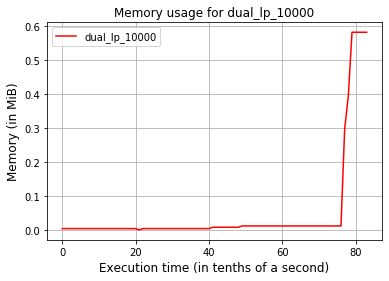

In [55]:
solo_memory_report(dual_lp_memory_4, "dual_lp_10000")

Peak usage for base    	   2.570312
Peak usage for dual    	   0.582031
Peak usage for Dijkstra	   1.566406
Peak usage for A-Star  	   1.007812



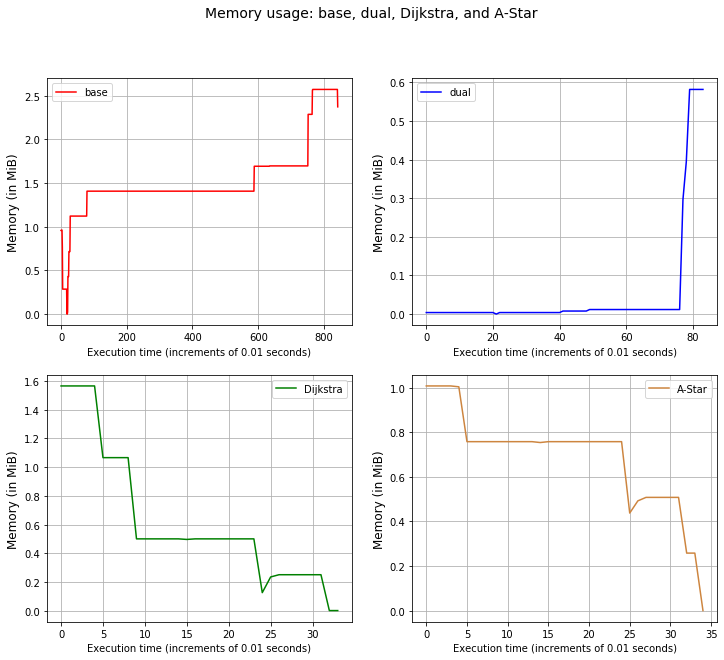

In [54]:
four_subplot_memory_report(base_lp_memory_4, dual_lp_memory_4, dijkstra_memory, astar_memory, "base", "dual", "Dijkstra", "A-Star")

Peak usage for base    	   2.570312
Peak usage for dual    	   0.582031
Peak usage for Dijkstra	   1.566406
Peak usage for A-Star  	   1.007812



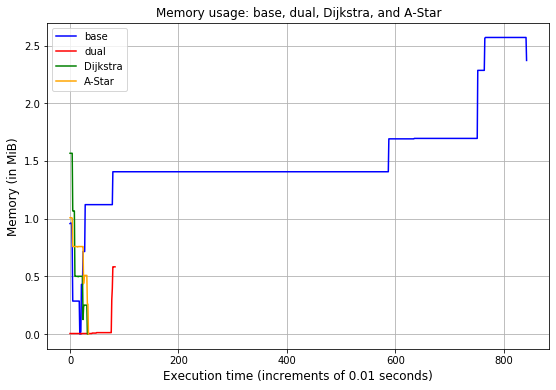

In [29]:
four_way_memory_report(base_lp_memory_4, dual_lp_memory_4, dijkstra_memory, astar_memory, "base", "dual", "Dijkstra", "A-Star")

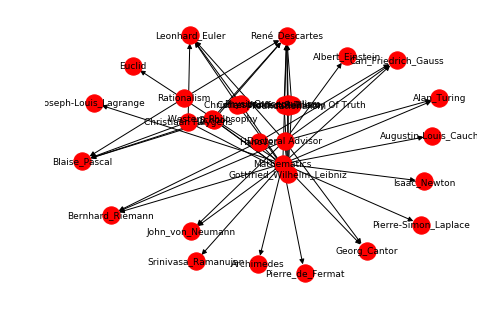

In [32]:

z0 = [('Hanover', 'Gottfried_Wilhelm_Leibniz'),
 ('Hanover', 'Carl_Friedrich_Gauss'),
 ('Hanover', 'Bernhard_Riemann'),
 ('Western Philosophy', 'Gottfried_Wilhelm_Leibniz'),
 ('Western Philosophy', 'Blaise_Pascal'),
 ('Western Philosophy', 'René_Descartes'),
 ('School', 'Gottfried_Wilhelm_Leibniz'),
 ('School', 'Blaise_Pascal'),
 ('School', 'René_Descartes'),
 #('Rationalism', 'Gottfried_Wilhelm_Leibniz'), #To illustrate a longer than 2 click path
 ('Rationalism', 'Blaise_Pascal'),
 ('Rationalism', 'René_Descartes'),
 ('Foundationalism', 'Gottfried_Wilhelm_Leibniz'),
 ('Foundationalism', 'René_Descartes'),
 ('Conceptualism', 'Gottfried_Wilhelm_Leibniz'),
 ('Conceptualism', 'René_Descartes'),
 ('Indirect Realism', 'Gottfried_Wilhelm_Leibniz'),
 ('Indirect Realism', 'René_Descartes'),
 ('Correspondence Theory Of Truth', 'Gottfried_Wilhelm_Leibniz'),
 ('Correspondence Theory Of Truth', 'René_Descartes'),
 ('Doctoral Advisor', 'Gottfried_Wilhelm_Leibniz'),
 ('Doctoral Advisor', 'Leonhard_Euler'),
 ('Doctoral Advisor', 'Carl_Friedrich_Gauss'),
 ('Doctoral Advisor', 'Bernhard_Riemann'),
 ('Doctoral Advisor', 'John_von_Neumann'),
 ('Doctoral Advisor', 'Alan_Turing'),
 ('Doctoral Advisor', 'Georg_Cantor'),
 ('Doctoral Advisor', 'Albert_Einstein'),
 ('Christiaan Huygens', 'Gottfried_Wilhelm_Leibniz'),
 ('Christiaan Huygens', 'Leonhard_Euler'),
 ('Christiaan Huygens', 'Blaise_Pascal'),
 ('Christian Wolff', 'Gottfried_Wilhelm_Leibniz'),
 ('Christian Wolff', 'Leonhard_Euler'),
 ('Mathematics', 'Gottfried_Wilhelm_Leibniz'),
 ('Mathematics', 'Euclid'),
 ('Mathematics', 'Carl_Friedrich_Gauss'),
 ('Mathematics', 'Isaac_Newton'),
 ('Mathematics', 'Bernhard_Riemann'),
 ('Mathematics', 'Augustin-Louis_Cauchy'),
 ('Mathematics', 'John_von_Neumann'),
 ('Mathematics', 'Joseph-Louis_Lagrange'),
 ('Mathematics', 'Alan_Turing'),
 ('Mathematics', 'Georg_Cantor'),
 ('Mathematics', 'Pierre_de_Fermat'),
 ('Mathematics', 'Pierre-Simon_Laplace'),
 ('Mathematics', 'Srinivasa_Ramanujan'),
 ('Mathematics', 'Archimedes'),
 ('Mathematics', 'René_Descartes'),
 ('Physics', 'Gottfried_Wilhelm_Leibniz'),
 ('Physics', 'Leonhard_Euler'),
 ('Gottfried_Wilhelm_Leibniz','Mathematics')]


#Nodes
z1 = ['Hanover', 'Western Philosophy', 'School', 'Rationalism',
       'Foundationalism', 'Conceptualism', 'Indirect Realism',
       'Correspondence Theory Of Truth', 'Doctoral Advisor',
       'Christiaan Huygens', 'Christian Wolff', 'Mathematics', 'Physics',
       'Gottfried_Wilhelm_Leibniz', 'Carl_Friedrich_Gauss',
       'Bernhard_Riemann', 'Blaise_Pascal', 'René_Descartes',
       'Leonhard_Euler', 'John_von_Neumann', 'Alan_Turing',
       'Georg_Cantor', 'Albert_Einstein', 'Euclid', 'Isaac_Newton',
       'Augustin-Louis_Cauchy', 'Joseph-Louis_Lagrange',
       'Pierre_de_Fermat', 'Pierre-Simon_Laplace', 'Srinivasa_Ramanujan',
       'Archimedes']

#init graph object
G = nx.Graph()
G_2 = nx.DiGraph()

#Substantiate graph object with nodes and edges
#G.add_edges_from(list(G_prime.edges)[:10])
G.add_edges_from(z0)
G.add_nodes_from(z1)
G_2.add_edges_from(z0)
G_2.add_nodes_from(z1)
nx.draw(G_2, with_labels = True, font_size = 9)


#Creates a dictionary of the node IDs to the values for later lookup and reverse lookup
nodes_ = list(G_2.nodes)
nodes_dict = dict(zip(range(0,len(nodes_)),nodes_)) #    {0: 'Hanover', 1: 'Gottfried_Wilhelm_Leibniz',..}
nodes_dict_rev = dict(zip(nodes_,range(0,len(nodes_))))# {'Hanover': 0,'Gottfried_Wilhelm_Leibniz': 1,..}
nodes_ = list(nodes_dict.keys())


#Define start and end node. Node A to B
start_node = nodes_dict_rev['Gottfried_Wilhelm_Leibniz']
end_node = nodes_dict_rev['Alan_Turing']


#Create a dictionary of nodes and their net demands
#Iterates through each node and adds it to the node demand
# dictionary with a net demand of 0, then sets the supply
# and demand node of the network problem to -1 and 1 
# respectively
net_ds_nodes_ = {} #{0: [-1, 0], 1: [0, 0], 2: [0, 0],... 8: [0,1], ... }
for node in nodes_:
    net_ds_nodes_[node] = [0,0]
net_ds_nodes_[start_node] = [-1,0]
net_ds_nodes_[end_node] = [0,1]


#Creates a dictionary of arcs3
arcs_ = list(G_2.edges)

#Creates a dictionary for each arc and swapping the node values for node IDs
arcs_dict = {}

for a,b in arcs_:
    x = nodes_dict_rev[a]
    y = nodes_dict_rev[b]
    arcs_dict[(x,y)] = (a,b)


arcs_ = list(arcs_dict.keys())

#Costs, lower bound, upper bound
arcData_ = dict(zip(arcs_, [[1,0,1]]*len(arcs_)))

#Makes it easy to reference a dictionary with subdicts
supply_,demand_ = splitDict(net_ds_nodes_)
(costs_,mins_,maxs_) = splitDict(arcData_)


arcData_ = dict(zip(arcs_, [[1,0,1]] * len(arcs_)))


supply_, demand_ = splitDict(net_ds_nodes_)
(costs_, mins_, maxs_) = splitDict(arcData_)


# Gurobi Primal LP

In [33]:

# Here we created a dictionary of the arcs as the keys, and the values as the cost. Looks like this:
# {(1,4): 1,
#  (3,7): 1,
#   etc...} 
  
# The multidict is a gurobi function that allows you to reference the dict.keys() and dict.values()
# easily. We called them arcs, cost
arcs, cost = multidict(dict(zip(arcs_,[1]*len(arcs_))))

#Init model
m = Model("Gurobi_base_LP")

# Here we add the arcs as variables to "flow". We use obj = cost to say that the objective
# is to minimize the cost (which is 1 for every edge). Gurobi's default is to MINIMIZE,
# and has a feature where you can declare the objective right in the definition of the variables.
flow = m.addVars(arcs, obj=cost, name="flow")


# Here we add the constraints for the "intermediate nodes" where their inflows - outflows = 0.
# The arcs.select() is a gurobi function that allows us a wildcard selection. This is the key
# as it allows us to avoid the list comprehension that was screwing us over. 
m.addConstrs(
  (quicksum(flow[i,j] for i,j in arcs.select('*',j)) ==
    quicksum(flow[j,k] for j,k in arcs.select(j,'*'))
    for j in nodes_ if not((j == start_node) or (j==end_node))), "node")

m.addConstrs(
  (quicksum(flow[i,j] for i,j in arcs.select('*',j)) -
    quicksum(flow[j,k] for j,k in arcs.select(j,'*')) == -1
    for j in nodes_ if (j == start_node)), "start_node")
    
m.addConstrs(
  (quicksum(flow[i,j] for i,j in arcs.select('*',j)) -
    quicksum(flow[j,k] for j,k in arcs.select(j,'*')) == 1
    for j in nodes_ if (j == end_node)), "end_node")

# Compute optimal solution
m.optimize()

# Print solution
if m.status == GRB.Status.OPTIMAL:
    solution = m.getAttr('x', flow)

    for i,j in arcs:
        if solution[i,j] > 0:
            print('%s -> %s: %g' % (i, j, solution[i,j]))


Optimize a model with 31 rows, 50 columns and 100 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 31 rows and 50 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.000000000e+00
1 -> 21: 1
21 -> 16: 1


# Gurobi Dual LP


In [39]:

# Here we created a dictionary of the nodes as the keys, and the values as the cost. Looks like this:
# {(1: 1,
#   2: 1,
#   3: 1,
#   etc...} 
  
# The multidict is a gurobi function that allows you to reference the dict.keys() and dict.values()
# easily. We called them nodes, cost
nodes, cost = multidict(dict(zip(nodes_,[1]*len(arcs_))))

#init model
m = Model("Gurobi_base_LP")


# Here we add the model decision variables into "flow". We do not write the objective function into
# this declaration, because it is a little bit different.
flow = m.addVars(nodes, name="flow")


#Here we set the objective. I don't know a good intution for this. We choose maximize.
m.setObjective(-flow[start_node] + flow[end_node], GRB.MAXIMIZE)


# Theres only one constraint for the dual. It basically says that for every arc we want the difference
# in value at the inflow node and outflow node to be less than or equal one.  To me,
# the intuition here is that the its constraining the edges to be connected. 
m.addConstrs((flow[e[1]] - flow[e[0]] <= 1 for e in arcs_), "constr")

# Compute optimal solution
m.optimize()

# Print solution
if m.status == GRB.Status.OPTIMAL:
    solution = m.getAttr('x', flow)
    print(solution)


Optimize a model with 50 rows, 31 columns and 100 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 50 rows and 31 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.000000000e+00
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 1.0, 14: 0.0, 15: 0.0, 16: 2.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 1.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0}
